In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from arima import arima
import urllib.request
from scipy import stats

In [2]:
# Download Core CPI data from FRED
url = 'https://fred.stlouisfed.org/series/CPILFESL/downloaddata/CPILFESL.csv'
source = urllib.request.urlopen(url).read().decode('utf-8').split("\n")
df_monthly = pd.read_csv(url, header=0, parse_dates=[0], index_col=0, squeeze=True, names = ['Dates', 'Inflation'])

# Monthly to Quarterly
resample = df_monthly.resample('Q')
df_quarterly = resample.mean()

# Annualized QoQ growth
df_yoy = df_quarterly.pct_change(periods=1)*400
df_yoy = df_yoy[1:,]

# Convert to numpy
pi=df_yoy.values


In [3]:
# IMA(1,1)

p, d, q = 0, 1, 1

# Model Instance
ima = arima(p, d, q, pi)

# AR coefficients, MA coefficients, log likelihood, errors 
phi, theta, L, epsilon, v2 = ima.phi, ima.theta, ima.L, ima.epsilon, ima.v2

### Beveridge Nelson Decomposition

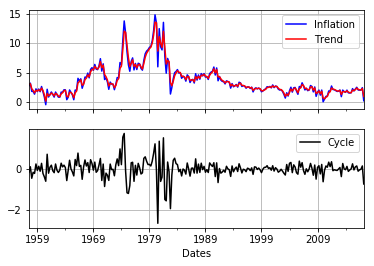

In [4]:
# Beveridge Nelson Decomposition

# cycle: c_{t} = theta * epsilon_{t}
c = -theta * epsilon

# trend: z_{t} = z_[t-1] + (1-theta) * epsilon_{t}
z = np.empty_like(c)
z = pi[1:,] - c
    
idx = len(df_yoy) - len(z)

# Pandas dataframes for easy plotting
df_z = pd.DataFrame(z,index=df_yoy.index[idx:,])
df_c = pd.DataFrame(c,index=df_yoy.index[idx:,])
df_z.columns = ['Trend']
df_c.columns = ['Cycle']
df_yoy_plot = df_yoy[idx:,]

# Plot 
fig, axes = plt.subplots(nrows=2, ncols=1)
df_yoy_plot.plot(ax=axes[0], style='b', legend=True, sharex=True)
df_z.plot(ax=axes[0], style='r', legend=True, grid=True, sharex=True) # Plot trend
df_c.plot(ax=axes[1], style='k', legend=True, grid=True, sharex=True) # Plot cycle
plt.show()


### Time series and density of the residuals

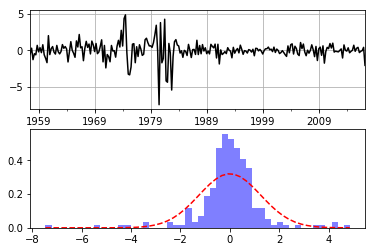

In [5]:
df_epsilon = pd.DataFrame(epsilon,index=df_yoy.index[idx:,])
df_epsilon.columns = ['Residuals']

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
df_epsilon.plot(ax=axes[0], style='k', legend=False, grid=True)

num_bins=50
n, bins, patches = plt.hist(epsilon, num_bins, normed=1, facecolor='b', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, 0, ima.v2)
plt.plot(bins, y.T, 'r--')
plt.show()

### Spectal density

$S_{(1-L)\pi_t}(\omega) = | 1 + \theta e^{-i \omega} | ^ {2} \sigma_{\epsilon}^2$

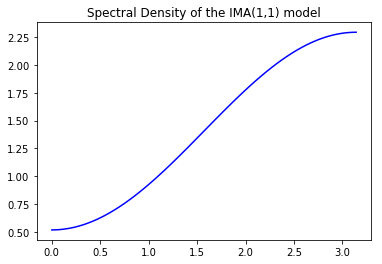

In [6]:
omega = np.linspace(0 , np.pi, 100)
S = np.abs((1+theta * np.exp(-1j * omega)))**2 * v2

plt.plot(omega, S.T, color='b')
plt.title('Spectral Density of the IMA(1,1) model')
plt.show()

### Rolling Estimation

In [7]:
# Number of quarters
q = 10*4

# initialize for storage
store_theta = np.empty([len(pi)-int(q)+1,])
store_v2 = np.empty([len(pi)-int(q)+1,])
    
# Run estimation with a rolling window
for t in range(int(q), len(pi)+1):
    pi_temp = pi[t-int(q):t]
    ima = arima(0, 1, 1, pi_temp)
    store_theta[t-int(q)] = ima.theta
    store_v2[t-int(q)] = ima.v2
    
df_theta = pd.DataFrame(store_theta ,index=df_yoy.index[int(q)-1:,])
df_v2 = pd.DataFrame(store_v2 ,index=df_yoy.index[int(q)-1:,])
df_theta.columns = ['10 years']
df_v2.columns = ['10 years']

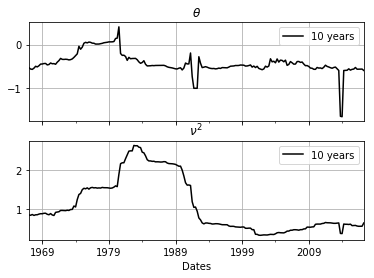

In [8]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1)
df_theta.plot(color='k', ax=axes[0], title=r'$\theta$', sharex=True, grid=True)
df_v2.plot(color='k', ax=axes[1], title=r'$\nu^2$', sharex=True, grid = True)
plt.show()